In [1]:
import torch
from torchvision import models
from datasets import *
from tqdm import tqdm
import imageio
import urllib.request
import cv2
import os
from PIL import Image

In [2]:
teacher = models.efficientnet_b0(weights='DEFAULT').to('cuda').eval()
student = models.shufflenet_v2_x0_5(weights='DEFAULT').to('cuda').eval()

In [3]:
test_tf = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ConvertImageDtype(torch.float),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

val_loader = load_imagenet(64,1234,False)
def get_label(idx):
    return val_loader.dataset.class_name_map[val_loader.dataset.class_id_list[idx]]

In [4]:
def save_gif(url,fname):
    os.mkdir(fname.split(".")[0])

    ## Read the gif from the web, save to the disk
    imdata = urllib.request.urlopen(url).read()
    imbytes = bytearray(imdata)
    open(fname,"wb+").write(imdata)

    ## Read the gif from disk to `RGB`s using `imageio.miread` 
    gif = imageio.mimread(fname)
    print("Total {} frames in the gif!".format(len(gif)))

    for i,img in enumerate(gif):
        cv2.imwrite(fname.split(".")[0]+"/"+str(i)+".png", cv2.cvtColor(img[:,:,:3],cv2.COLOR_BGR2RGB))

In [20]:
def inf_gif(url,fname,model):

    ## Read the gif from the web, save to the disk
    imdata = urllib.request.urlopen(url).read()
    imbytes = bytearray(imdata)
    open(fname,"wb+").write(imdata)

    ## Read the gif from disk to `RGB`s using `imageio.miread` 
    gif = imageio.mimread(fname)
    print("Total {} frames in the gif!".format(len(gif)))

    preds = torch.zeros(len(gif))
    with torch.no_grad():
        for i,img in enumerate(gif):
            frame = cv2.cvtColor(np.array(img[:,:,:3]),cv2.COLOR_BGR2RGB)
            frame = transforms.ToTensor()(frame).to('cuda')
            preds[i] = model(test_tf(frame).unsqueeze(0)).argmax()

    return preds

In [29]:
c = "ice bear"
c = "fire engine"
paths = {'ice bear':"https://i.gifer.com/67Kr.gif",'fire engine':"https://media.tenor.com/BqedYho27HAAAAAC/station19-fire-truck.gif"}

preds_s = inf_gif(paths[c],"test.gif",student)
preds_t = inf_gif(paths[c],"test.gif",teacher)

s_count = 0
t_count = 0
for pred in preds_s:
    if get_label(int(pred))[1:] == c:
        s_count += 1
for pred in preds_t:
    if get_label(int(pred))[1:] == c:
        t_count += 1
print(f"s: {s_count/len(preds_s)}, t: {t_count/len(preds_t)}")

Total 35 frames in the gif!
Total 35 frames in the gif!
s: 0.0, t: 0.0


In [36]:
import pandas as pd

dfs = []
for percent in [0,25,50,75,100]:
    # open the text file and read the lines into a list
    with open(str(percent)+'.txt', 'r') as f:
        lines = f.readlines()

    # create an empty list to hold the dictionaries
    data = []

    # loop over the lines and extract the key-value pairs
    for line in lines:
        parts = line.strip().split(', ')
        d = {}
        for part in parts:
            key, value = part.split(':')
            d[key] = value
        data.append(d)

    # convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(data)

    # convert the columns to their appropriate types (float, int, etc.)
    df = df.astype({'i': int, 'm': str, 'fps': float, 'rand': float, 'p': float, 'time': float})
    dfs.append(df)


Text(0, 0.5, 'FPS')

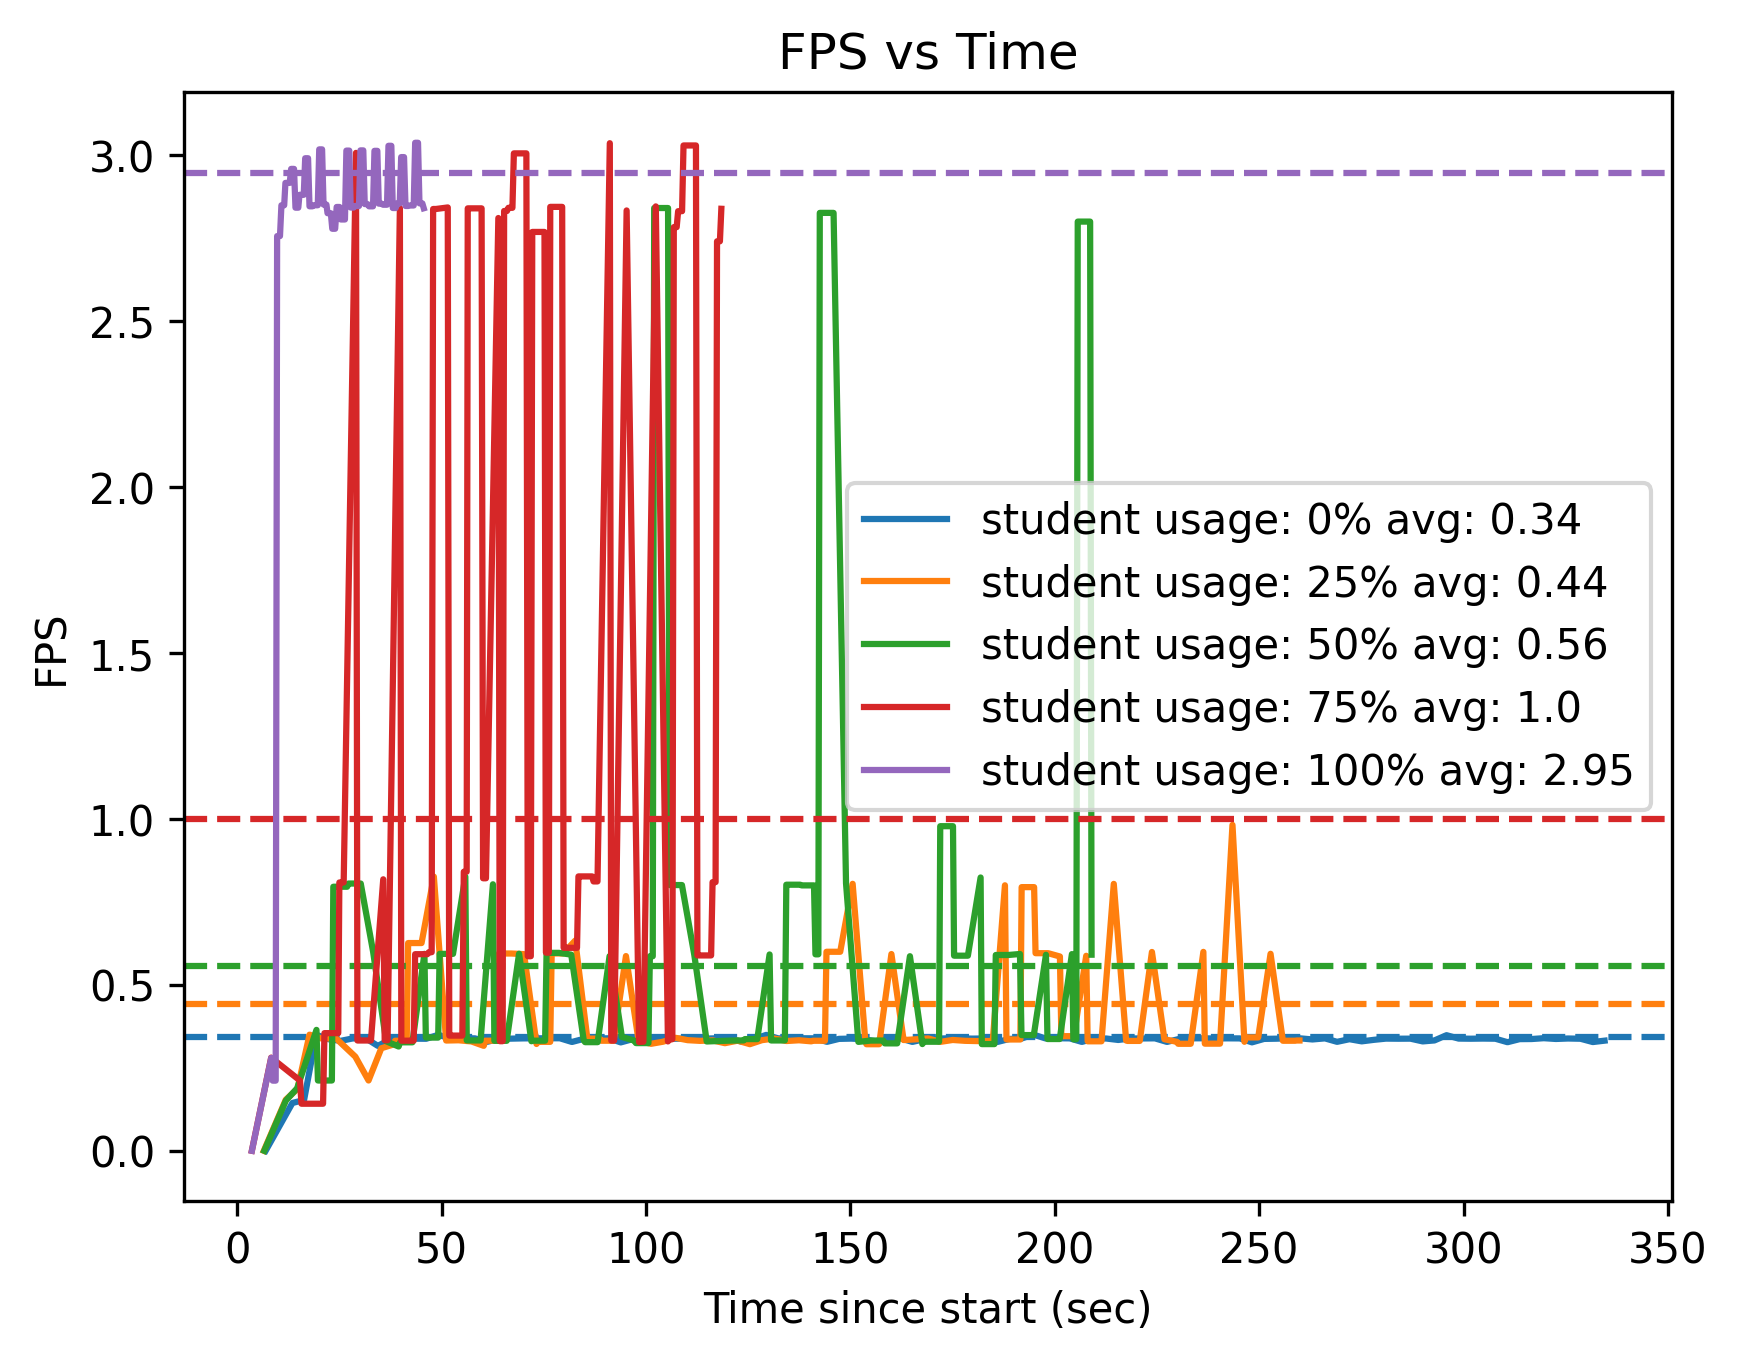

In [64]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
p = [0,25,50,75,100]
for i,df in enumerate(dfs):
    y = df['fps'].values
    x = df['time'].values
    plt.plot(x,y,label="student usage: "+str(p[i])+"% avg: "+str(round(110/(x[-1]-x[1]),2)) ,c=cycle[i])
    plt.axhline(110/(x[-1]-x[1]),c=cycle[i],linestyle="--")
plt.legend() 
plt.title("FPS vs Time")
plt.xlabel("Time since start (sec)")
plt.ylabel("FPS")

# Prediction Confidence Over Time

In [4]:
model = models.resnet50(weights='DEFAULT').to('cuda').eval()

In [3]:
student = models.shufflenet_v2_x0_5(weights='DEFAULT').to('cuda')
with torch.no_grad():
    # first reinitialize the layer before classification to match the teacher feature dimensions
    student.conv5[0] = torch.nn.Conv2d(student.conv5[0].in_channels,teacher.classifier[1].in_features,kernel_size=(1, 1), stride=(1, 1), bias=False)
    student.conv5[1] = torch.nn.BatchNorm2d(teacher.classifier[1].in_features,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)

    # next create a new fc layer to match the teacher dimension
    student.fc = torch.nn.Linear(teacher.classifier[1].in_features,teacher.classifier[1].out_features)

    # freeze the classification layer
    for param in student.fc.parameters():
        param.requires_grad = False
student.load_state_dict(torch.load("best_batch_i288264sn_frozen_head_long1682578354.1065493.pth")['model_state_dict'])
student.to('cuda')
student.eval()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [6]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

In [7]:
# Define the class for single layer NN
class FC(torch.nn.Module):    
    # Constructor
    def __init__(self, input_size, output_size):
        super(FC, self).__init__()
        # hidden layer 
        self.fc = torch.nn.Linear(input_size, output_size)
    # prediction function
    def forward(self, x):
        return self.fc(x)
with torch.no_grad():
    shared_FC = FC(student.fc.in_features,student.fc.out_features)
    shared_FC.fc.weight[:,:] = student.fc.weight[:,:]
    shared_FC.fc.bias[:] = student.fc.bias[:]

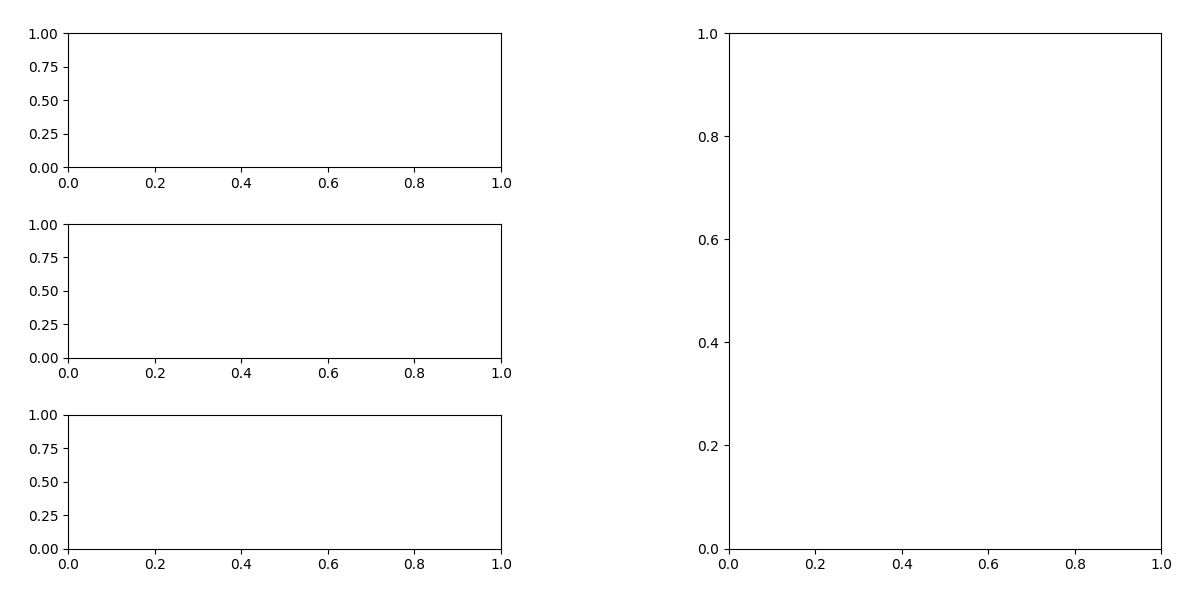

In [10]:
root_dir = "../../data/imagenet_vid_ytbb_robust/imagenet-vid-robust/val/"
# root_dir = "../../data/imagenet_vid_ytbb_robust/ytbb-robust/ytbb_videos/"
vid_dirs = os.listdir(root_dir)


preds = []
off = 0
# white storke 12
# tiger 3
# 47 airliner
# 4 warplane
dir_idx = 7
track_dict_student = {}
track_dict_teacher = {}
track_dict_teacher_big = {}
track_dicts = [track_dict_student, track_dict_teacher, track_dict_teacher_big]
models = [student,teacher,model]

emb = {}
def get_emb(name):
    def hook(model, input, output):
        emb[name] = input[0].detach()
    return hook

student.fc.register_forward_hook(get_emb('emb'))
teacher.classifier[1].register_forward_hook(get_emb('emb'))
model.fc.register_forward_hook(get_emb('emb'))

img_list = sorted(os.listdir(os.path.join(root_dir,vid_dirs[dir_idx])))

images = []
stud_embds = torch.zeros((len(img_list),student.fc.in_features))
teach_embds = torch.zeros((len(img_list),teacher.classifier[1].in_features))
model_embds = torch.zeros((len(img_list),model.fc.in_features))

stud_sms = torch.zeros((len(img_list),student.fc.out_features))
teach_sms = torch.zeros((len(img_list),teacher.classifier[1].out_features))
model_sms = torch.zeros((len(img_list),model.fc.out_features))

sm_scores = [stud_sms,teach_sms,model_sms]

# iterate over images in video
for i,img in enumerate(img_list):
    image = Image.open(os.path.join(root_dir,vid_dirs[dir_idx],img))
    images.append(image)
    for id,track_dict in enumerate(track_dicts):
        # get a prediction for the current frame
        with torch.no_grad():
            frame = transforms.ToTensor()(image).to('cuda')
            frame = test_tf(frame).unsqueeze(0)#+noise.to('cuda')
            sm_scores[id][i,:] = torch.nn.functional.softmax(models[id](frame).cpu().view(-1),dim=0)
        
        if id == 0:
            stud_embds[i,:] = emb['emb']
            with torch.no_grad():
                sm_scores[id][i,:] = torch.nn.functional.softmax(shared_FC(stud_embds[i]+off),dim=0)
        elif id == 1:
            teach_embds[i,:] = emb['emb']
        elif id == 2:
            model_embds[i,:] = emb['emb']


# get the top five averaged over the whole video
for id,track_dict in enumerate(track_dicts):
    # get the top5 on avg
    vals,idxs = torch.topk(sm_scores[id].mean(dim=0),5)
    # create the tracking stats
    for j,idx in enumerate(idxs):
        track_dict[idx.item()] = np.zeros(len(img_list))
    # fill in the conf scores
    for i, img in enumerate(img_list):
        for j,idx in enumerate(track_dict.keys()):
            track_dict[idx][i] = sm_scores[id][i,idx]

plt.close()
fig,ax = plt.subplot_mosaic([['shufflenet_v2_x0_5','space','image'],
                              ['efficientnet_b0','space','image'],
                              ['resnet_50','space','image'],],figsize=(12,6),
                              gridspec_kw={'width_ratios':[0.5,0.1,0.5],
                                           'height_ratios': [1,1,1]})
fig.tight_layout(pad=2.0)
ax['space'].axis('off')
names = ["shufflenet_v2_x0_5","efficientnet_b0","resnet_50"]
flops = ["40","400","4000"]

def animate(i):
    ax['image'].clear()
    id = 0
    for name,track_dict in zip(names,track_dicts):
        ax[name].clear()
        
        for k in track_dict.keys():
            ax[name].plot(np.arange(i+1),track_dict[k][:i+1],label=get_label(k))
            ax[name].set_xticks(np.arange(len(track_dict[k])))
        ax[name].set_xlim([0,len(img_list)-1])
        ax[name].grid()
        # ax[name].set_ylim([0,1])
        ax[name].set_title(name+" ("+flops[id]+" MFLOPS)")
        ax[name].set_ylabel('confidence (%)')
        if id == len(names)-1:
            ax[name].set_xlabel('frame #')
        ax[name].legend(loc="upper left",bbox_to_anchor=(1, 1))
        id += 1
        ax[name].set_yscale('log')
    ax['image'].imshow(images[i])
    

# run the animation
ani = FuncAnimation(fig, animate, frames=len(images), interval=300, repeat=False)

plt.show()

In [48]:
def cos_sim(t1,t2):
    t1 = t1.float()
    t2 = t2.float()
    return t1@t2/(torch.norm(t1)*torch.norm(t2))

def dist(t1,t2):
    t1 = t1.float()
    t2 = t2.float()
    return torch.sqrt(torch.sum(torch.square(t1-t2)))

stud_sims = torch.zeros(len(stud_embds))
stud_dists = torch.zeros(len(stud_embds))
teach_sims = torch.zeros(len(teach_embds))
teach_dists = torch.zeros(len(teach_embds))
model_sims = torch.zeros(len(model_embds))
model_dists = torch.zeros(len(model_embds))

for i, _ in enumerate(stud_embds):
    stud_sims[i] = cos_sim(stud_embds[0],stud_embds[i])
    stud_dists[i] = dist(stud_embds[0],stud_embds[i])
    teach_sims[i] = cos_sim(teach_embds[0],teach_embds[i])
    teach_dists[i] = dist(teach_embds[0],teach_embds[i])
    model_sims[i] = cos_sim(model_embds[0],model_embds[i])
    model_dists[i] = dist(model_embds[0],model_embds[i])

The bigger models are more robust to changes in the embedding

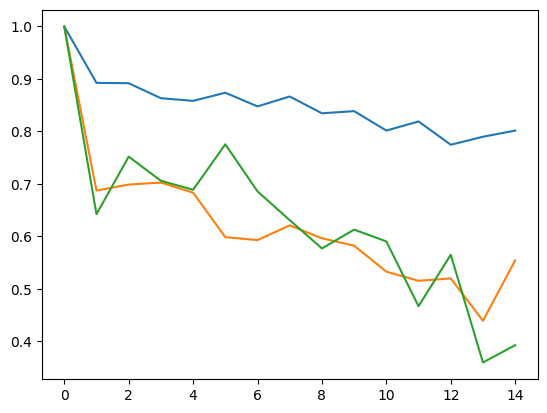

In [50]:
%matplotlib inline
plt.plot(stud_sims)
# plt.plot(stud_dists)
plt.plot(teach_sims)
# plt.plot(teach_dists)
plt.plot(model_sims)
# plt.plot(model_dists)

Evaluate a video sequence

In [4]:
from dataloader import *

In [5]:
vl = load_imagenetvid_robust(1)

In [4]:
big_teacher = models.resnet50(weights='DEFAULT').to('cuda').eval()

In [22]:
s_acc = 0
t_acc = 0
for idx, (img_seq,label_seq) in enumerate(tqdm(vl)):
    with torch.no_grad():
        # get the prediction
        s_preds = student(img_seq[0].to('cuda')).argmax(dim=1).to('cpu')
        t_preds = teacher(img_seq[0].to('cuda')).argmax(dim=1).to('cpu')

        # map to label idx
        for i,s_pred in enumerate(s_preds):
            s_preds[i] = vl.dataset.pred_idx_to_label_idx(s_pred.item())
            t_preds[i] = vl.dataset.pred_idx_to_label_idx(t_preds[i].item())

        s_acc += (s_preds == label_seq[0]).float().mean()
        t_acc += (t_preds == label_seq[0]).float().mean()
print(f"s_acc:{s_acc/len(vl)}")
print(f"t_acc:{t_acc/len(vl)}")

100%|██████████| 1021/1021 [00:38<00:00, 26.44it/s]

s_acc:0.26440873742103577
t_acc:0.4663006365299225


In [5]:
%matplotlib widget

In [6]:
from dataloader import *
from torchvision import models

vl = load_imagenetvid_robust(1)

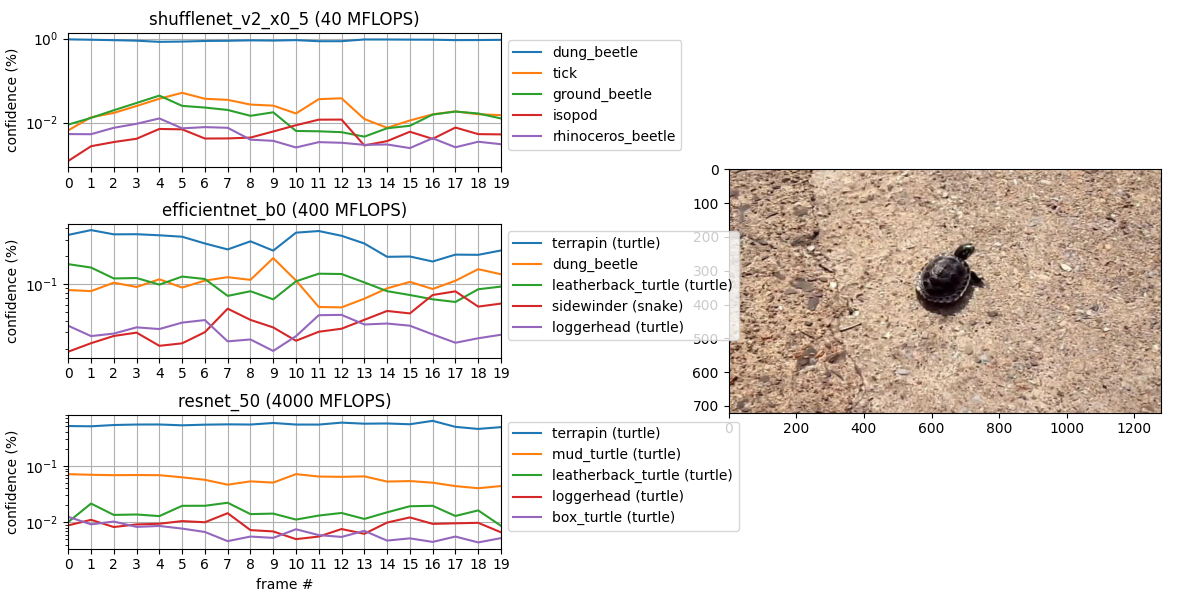

In [7]:
vl.dataset.visualize_vid(student.to('cpu'),teacher.to('cpu'),big_teacher.to('cpu'),idx=3)